# Explainable Machine Learning

In this notebook, we present our 5 approaches for Explainable Machine Learning problems.

Similarly, to the rest of the notebooks, the problems we address correspond to the Natural Language Processing domain, representing documents using tf-idf vectors.

Our dataset consists of spam or ham SMS documents and was taken from [Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

Our approaches consist of the following solutions:
- __White-box models__:
    - Logistic regression
    - Decision Tree
- __Black-box model interpretation - Random Forest__:
    - Global surrogate model - Logistic regression
    - Local surrogate model - Decision Tree
- __Label Power-Set__:
    - Permutation Importance

For more details and explanations the authors created a corresponding report in which the key results are further exlained and analyzed.

Happy reading and feel free to contact us for any further details.

## Preprocessing

Similary to other notebooks, we follow a preprocessing procedure.

### Loading the dataset

We load our dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_sms = pd.read_csv('spam_data.csv', encoding='latin-1')
df_sms.dropna(axis=1, inplace=True)
df_sms.columns = ['label', 'message']
df_sms

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


We display some statistics.

In [3]:
df_sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We encode ham SMS messages as 0 and spam SMS messages as 1.

In [4]:
df_sms['label'] = df_sms.label.map({'ham':0, 'spam':1})

### Tokenization

Next up, we are going to tokenize the SMS texts.

We begin by importing needed libraries.

In [5]:
import gensim
import nltk

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ceyx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We apply tokenization.

In [6]:
def tokenize(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(stemmer.stem(lemmatizer.lemmatize(token,'v')))
    return result

In [7]:
messages = df_sms['message'].map(tokenize)

### Bag-of-Words & TfIdf

In [8]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense

We transform text into tf-idf vectors.

In [9]:
dictionary = Dictionary(messages)
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in messages]

In [11]:
tfidf_corpus = TfidfModel(bow_corpus)[bow_corpus]
tfidf_corpus = corpus2dense(tfidf_corpus, num_terms=len(dictionary.token2id), num_docs=len(tfidf_corpus)).T

## Explainable Machine Learning algorithms

Next up, we create our Explainable Machine Learning models.

### White-box models

We begin with the white-box models.

We import all needed libraries.

In [12]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
sns.set(font_scale=2)

And prepare xs, ys, extract feature and target names and split into training and test set.

In [13]:
x = tfidf_corpus
y = df_sms['label']
feature_names = dictionary.token2id.keys()
target_names = ['ham', 'spam']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

#### Logistic Regression

We train our logistic regression model, specifying a high `C` value for regularization, in order to give higher weights to more important features (words).

In [14]:
log_reg = LogisticRegression(max_iter=1000, C=100)
log_reg.fit(x_train, y_train)

LogisticRegression(C=100, max_iter=1000)

We retrieve predictions on the training and test data.

In [15]:
y_predicted_train = log_reg.predict(x_train)
y_predicted_test = log_reg.predict(x_test)

We print the classification report with all metrics.

In [16]:
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1202
        spam       0.98      0.88      0.93       191

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



We display a barplot of the top 30 and top 10 words respectively.

In [17]:
weights = log_reg.coef_
model_weights = pd.DataFrame({'features':feature_names, 'weights':weights[0]})
model_weights = model_weights.iloc[model_weights.weights.abs().argsort()[::-1]]

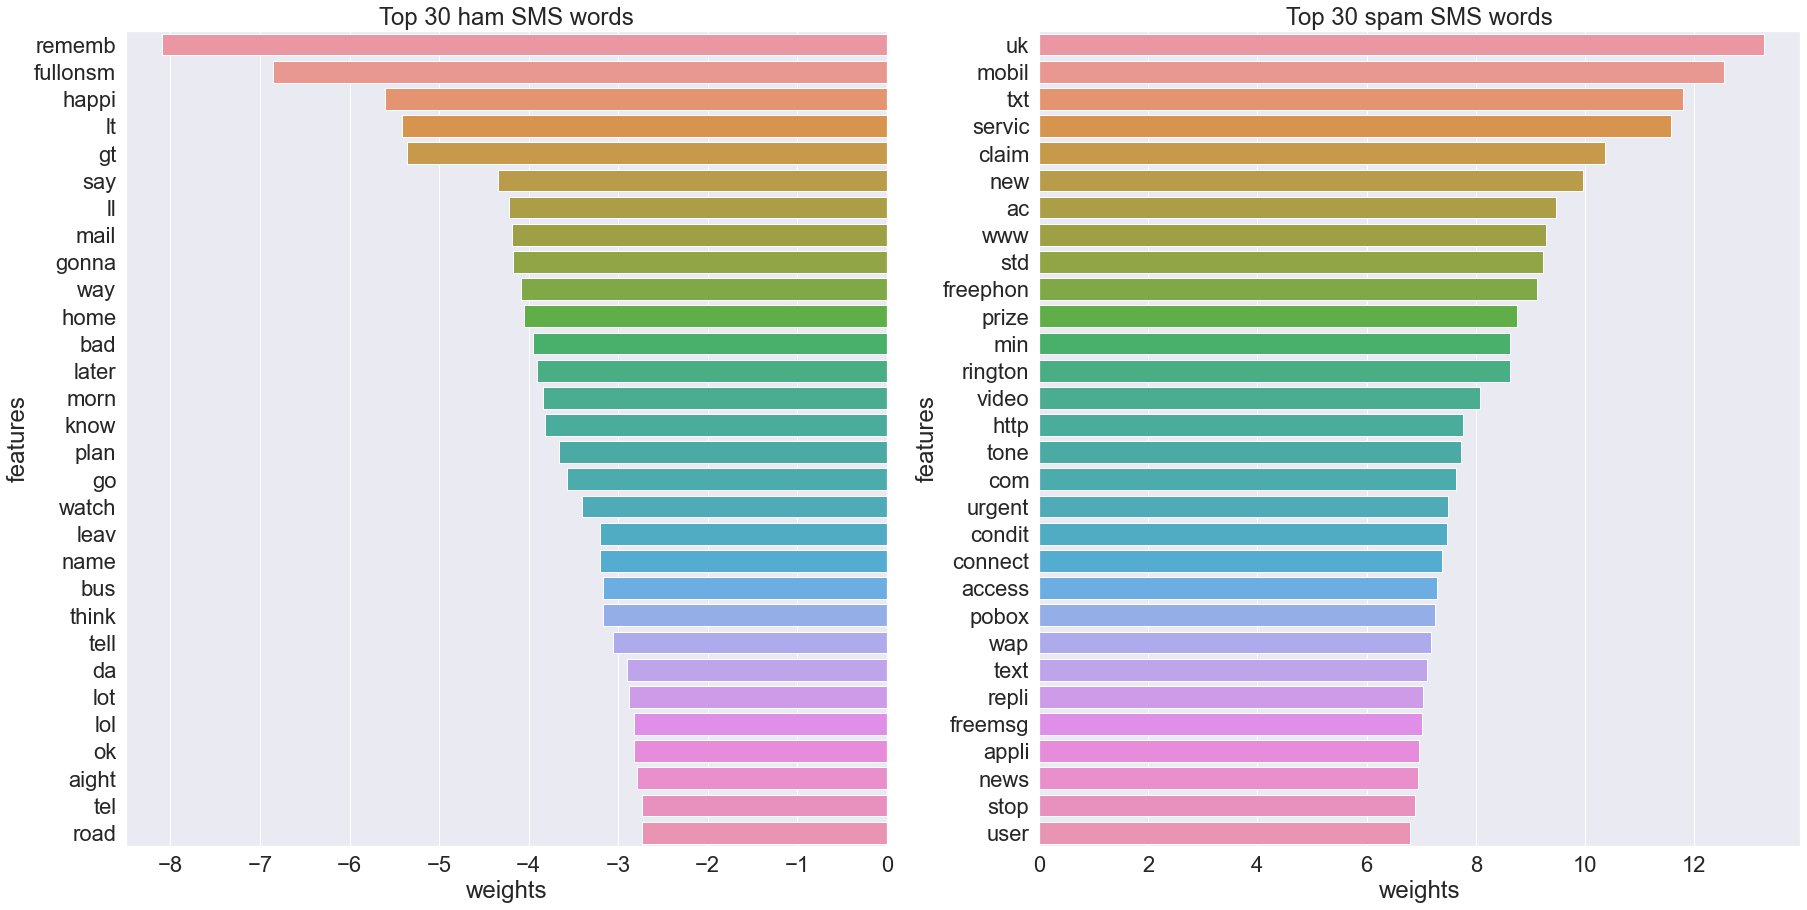

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 15), facecolor='w', edgecolor='k')

top_ham_model_weights = model_weights[model_weights['weights'] < 0][:30]
sns.barplot(x='weights', y='features', data=top_ham_model_weights, ax=axes[0])
axes[0].set_title('Top 30 ham SMS words')

top_spam_model_weights = model_weights[model_weights['weights'] >= 0][:30]
sns.barplot(x='weights', y='features', data=top_spam_model_weights, ax=axes[1])
axes[1].set_title('Top 30 spam SMS words')

plt.show()

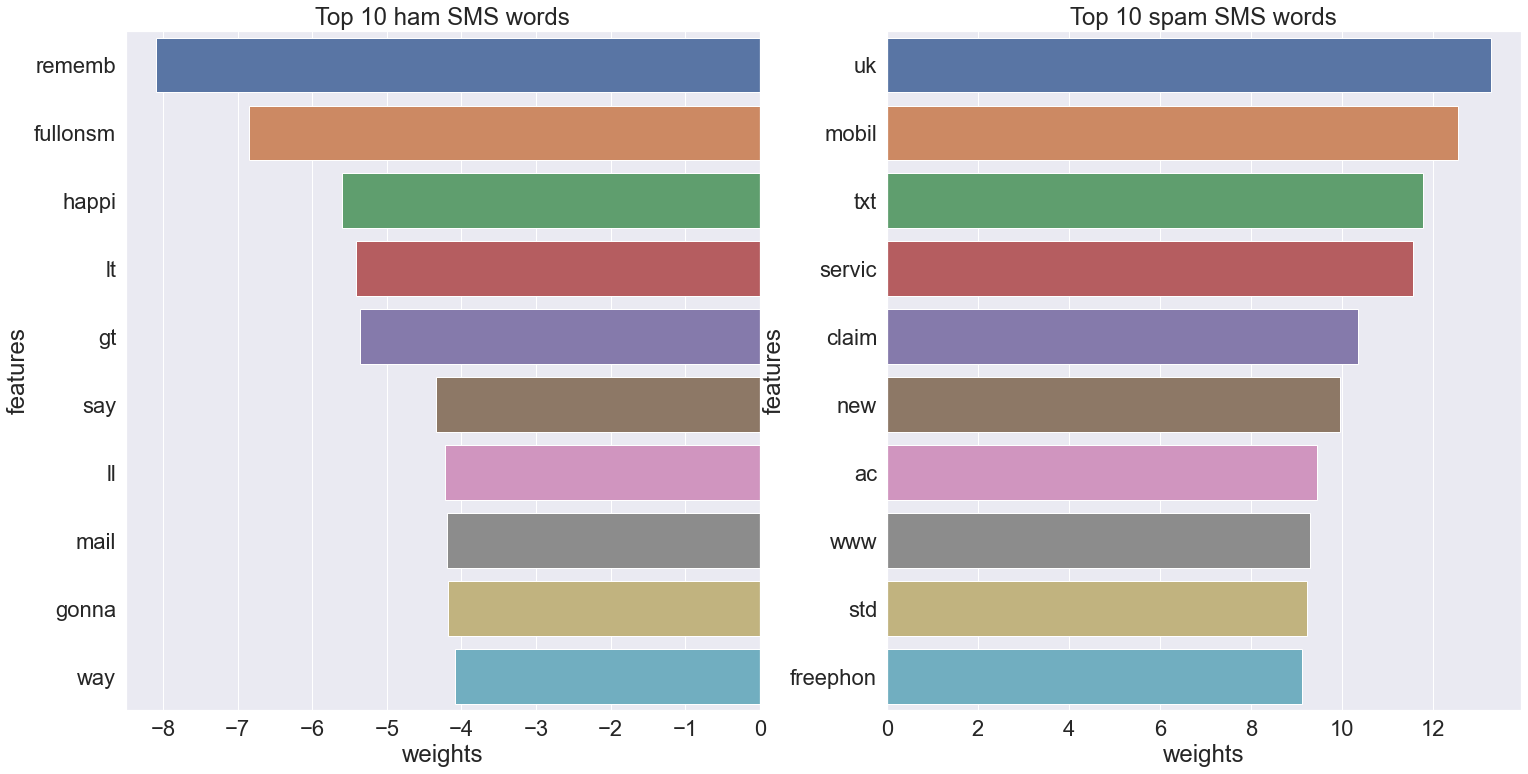

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12.5), facecolor='w', edgecolor='k')

top_ham_model_weights = model_weights[model_weights['weights'] < 0][:10]
sns.barplot(x='weights', y='features', data=top_ham_model_weights, ax=axes[0])
axes[0].set_title('Top 10 ham SMS words')

top_spam_model_weights = model_weights[model_weights['weights'] >= 0][:10]
sns.barplot(x='weights', y='features', data=top_spam_model_weights, ax=axes[1])
axes[1].set_title('Top 10 spam SMS words')

plt.show()

#### Decision Tree

Next, we train our Decision Tree model.

We follow a similar procedure.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

In [21]:
tree_clf = DecisionTreeClassifier(max_depth=30)
tree_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=30)

In [22]:
y_predicted_train = tree_clf.predict(x_train)
y_predicted_test = tree_clf.predict(x_test)

In [23]:
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1202
        spam       0.92      0.81      0.86       191

    accuracy                           0.96      1393
   macro avg       0.95      0.90      0.92      1393
weighted avg       0.96      0.96      0.96      1393



We plot our decision tree classifier.

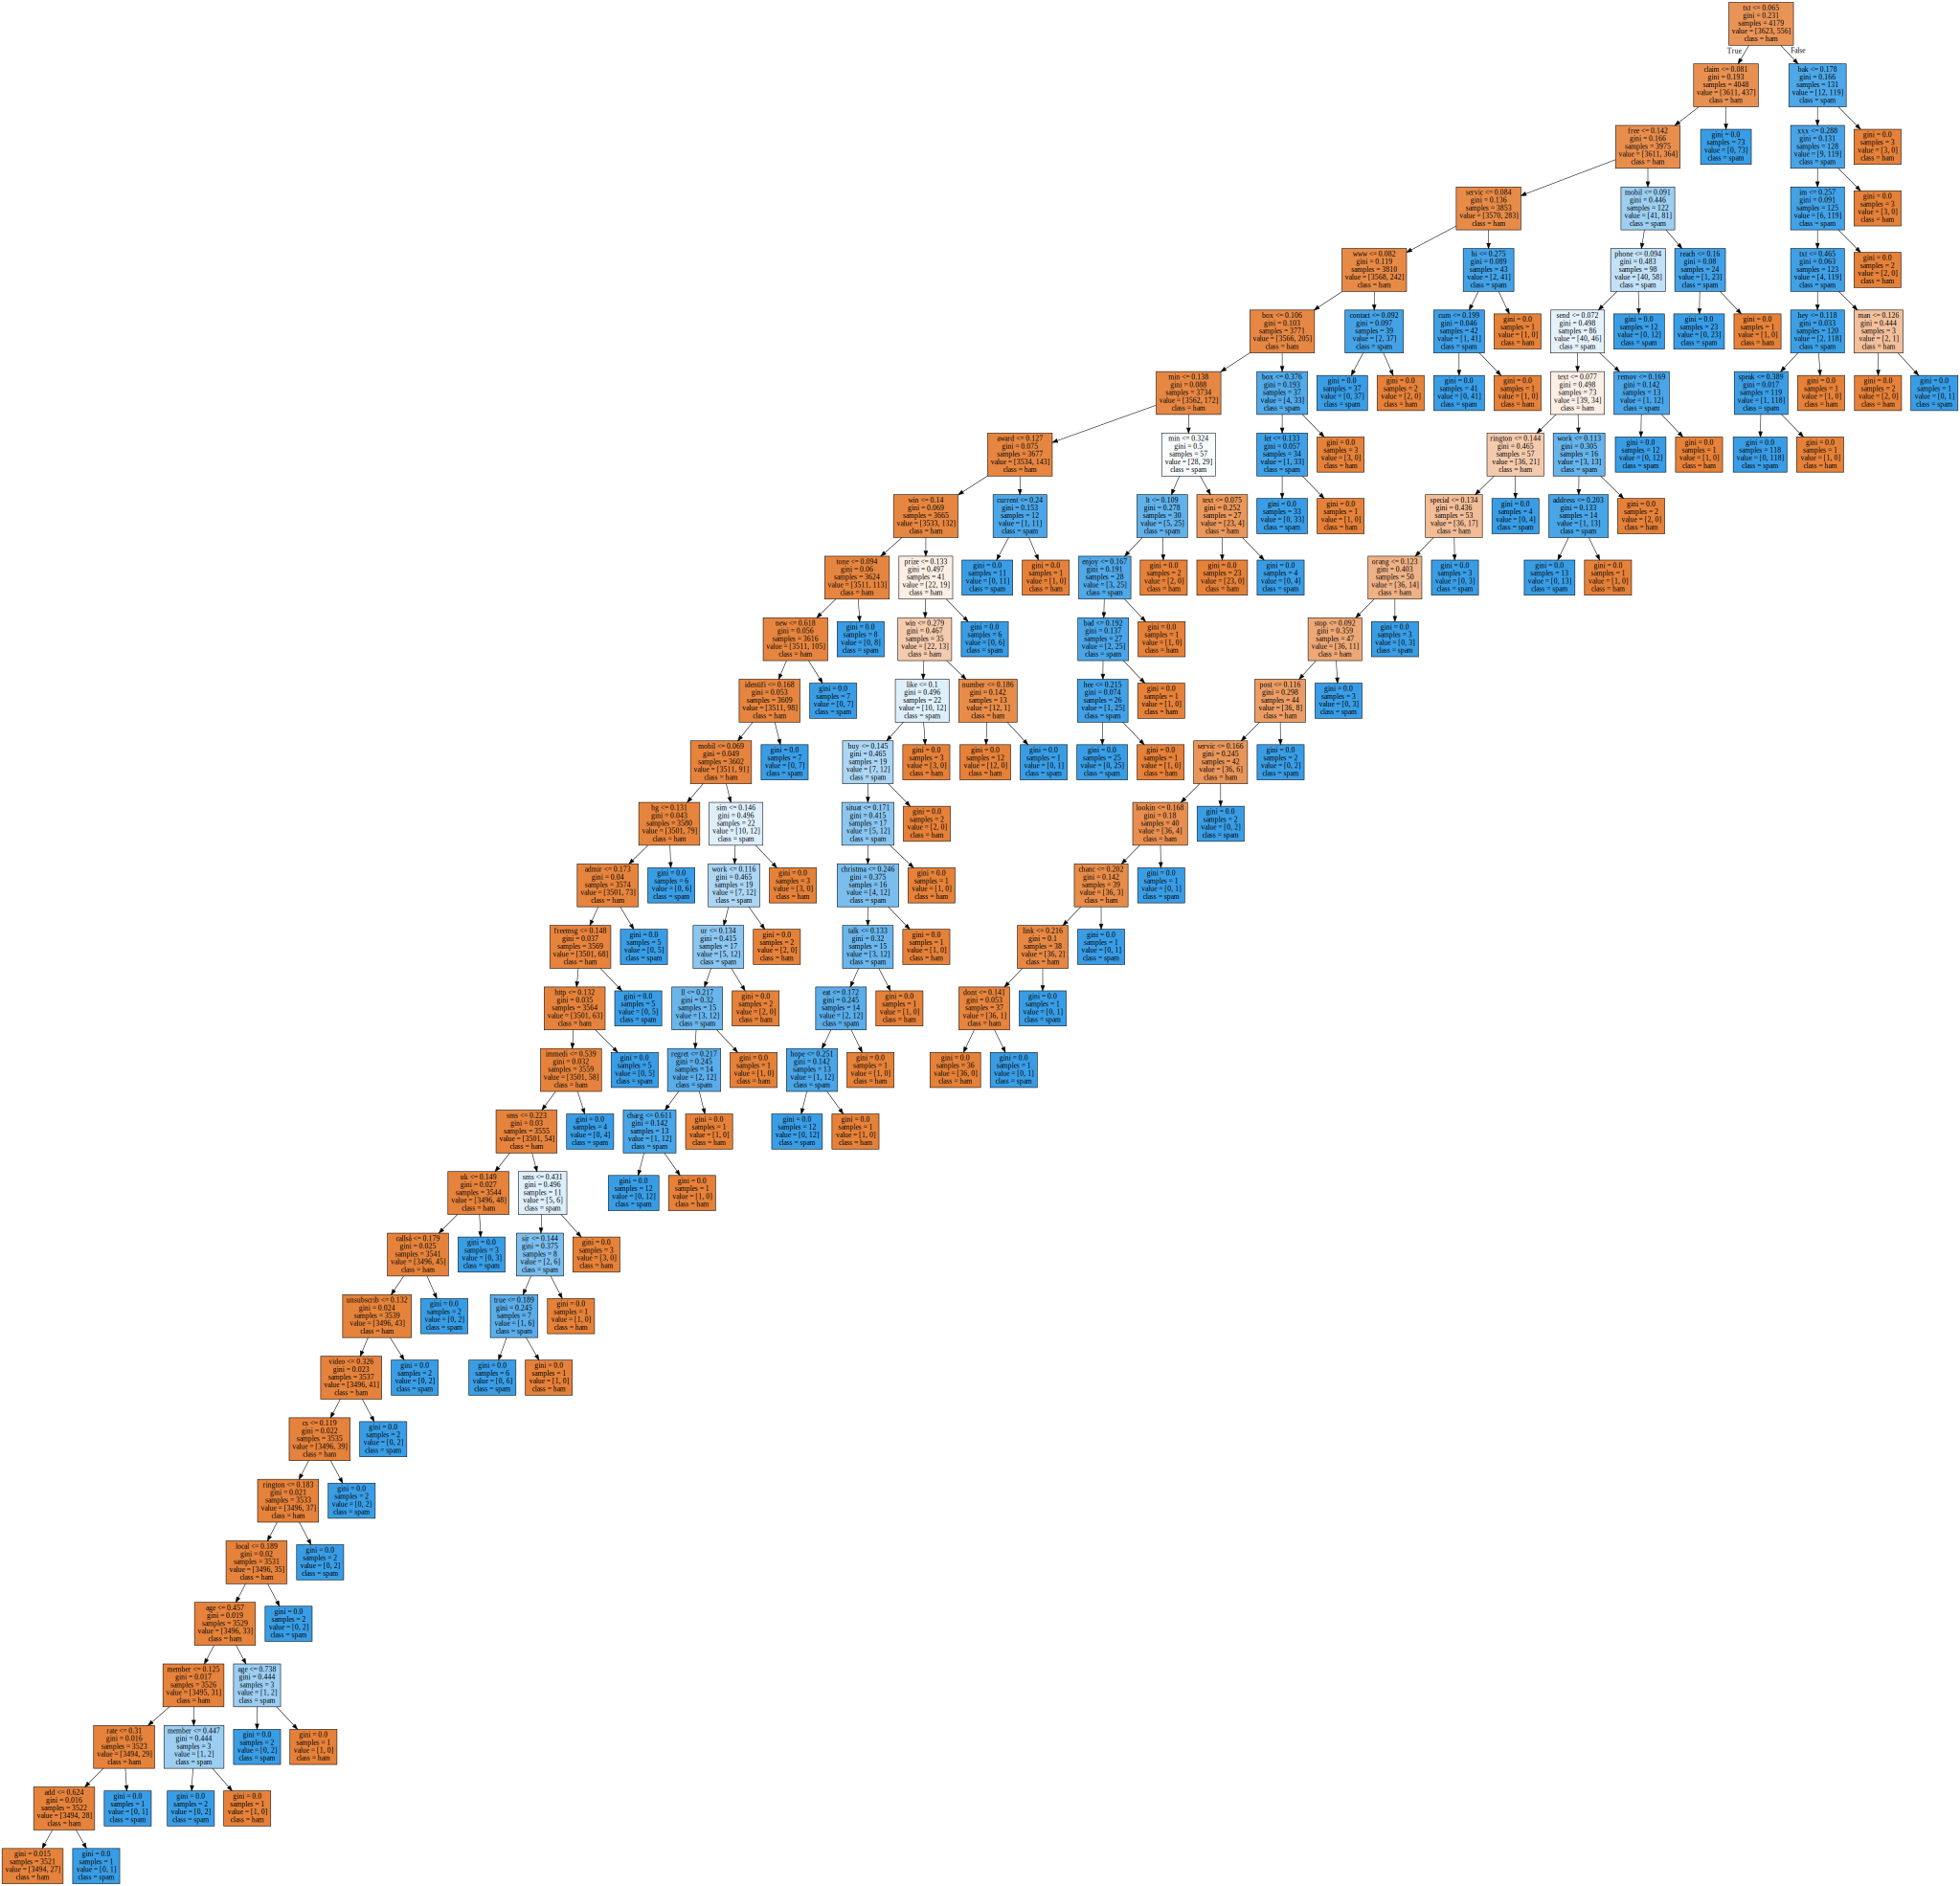

In [24]:
SVG(Source(
    export_graphviz(tree_clf, 
                    feature_names=list(feature_names), 
                    class_names=target_names, 
                    filled=True)
    ).pipe(format='svg')
   )

We display feature (word) importance in a barplot.

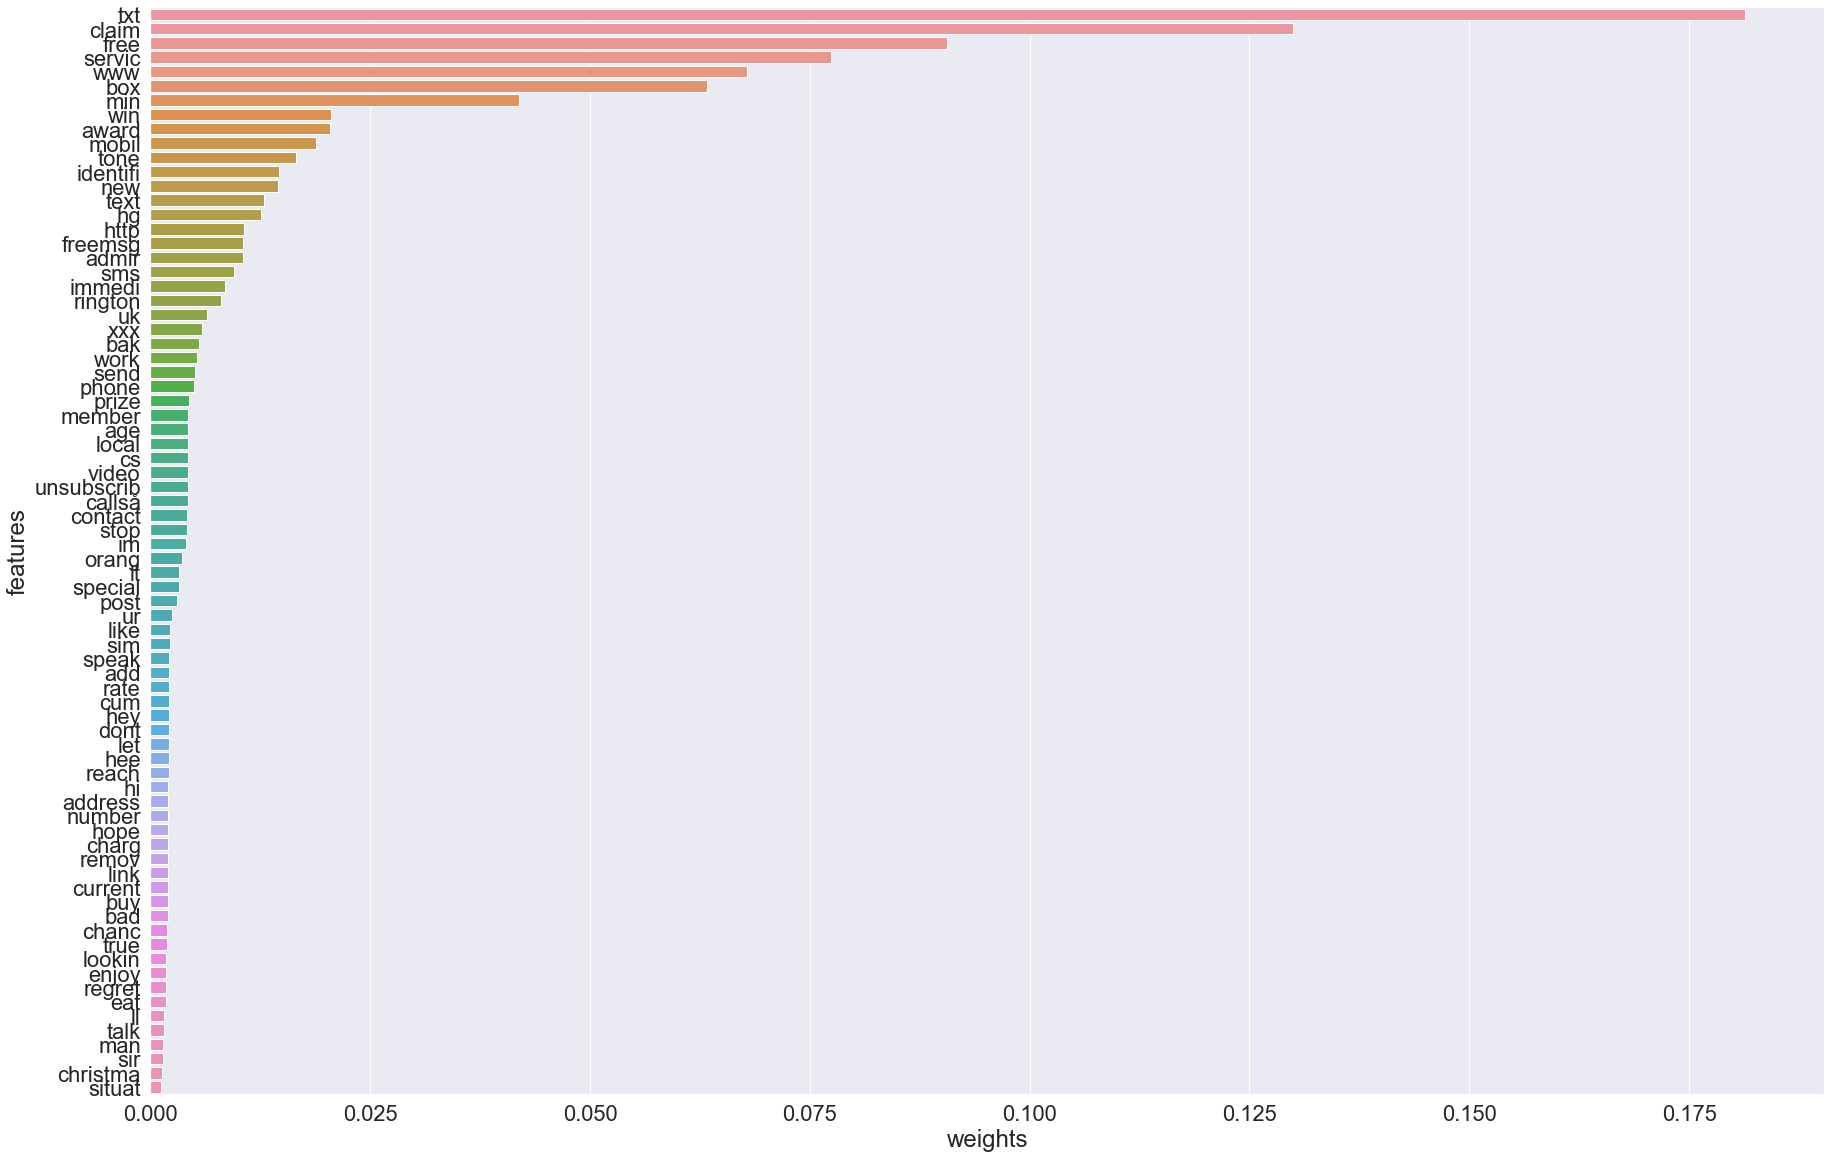

In [25]:
weights = tree_clf.feature_importances_
model_weights = pd.DataFrame({'features':feature_names, 'weights':weights})
model_weights = model_weights.sort_values('weights', ascending=False)
model_weights = model_weights[model_weights.weights > 0]
plt.figure(figsize=(30,20), facecolor='w', edgecolor='k')
sns.barplot(x='weights', y='features', data=model_weights);

We also display the top 30 most important words in a barplot once more.

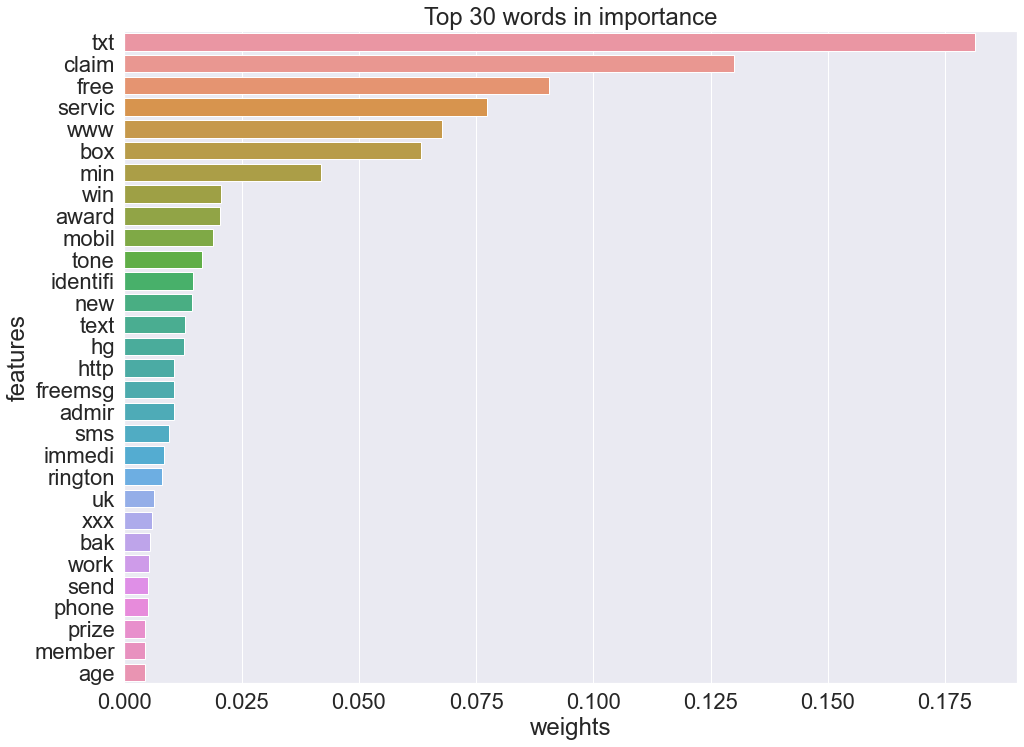

In [26]:
plt.figure(figsize=(16,12), facecolor='w', edgecolor='k')
sns.barplot(x='weights', y='features', data=model_weights[:30])
plt.title('Top 30 words in importance')
plt.show()

### Black-box model interpretation - Random Forest

For this part, we will train a Random Forest model, which we will then attempt to explain using a global and a local surrogate model.

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

RandomForestClassifier()

In [29]:
y_predicted_test = rf_clf.predict(x_test)

In [30]:
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1202
        spam       0.98      0.86      0.92       191

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393



We extract the new xs and ys to train our global surrogate model and to measure fidelity later on.

In [31]:
new_x_train = x_train
new_y_train = rf_clf.predict(x_train)

#### Global surrogate model - Logistic Regression

We train our logistic regression surrogate model.

In [32]:
log_reg_surrogate = LogisticRegression(max_iter=1000, C=100)
log_reg_surrogate.fit(new_x_train, new_y_train)

LogisticRegression(C=100, max_iter=1000)

And measure the fidelity and the accuracy.

In [33]:
y_surrogate_pred_test = log_reg_surrogate.predict(x_test)
print("Fidelity:", metrics.accuracy_score(y_predicted_test, y_surrogate_pred_test))
print("Accuracy:", metrics.accuracy_score(y_test, y_surrogate_pred_test))

Fidelity: 0.9892318736539842
Accuracy: 0.9820531227566404


We display a barplot of the top 30 and top 10 words respectively.

In [34]:
weights = log_reg_surrogate.coef_
model_weights = pd.DataFrame({'features':feature_names, 'weights':weights[0]})
model_weights = model_weights.iloc[model_weights.weights.abs().argsort()[::-1]]

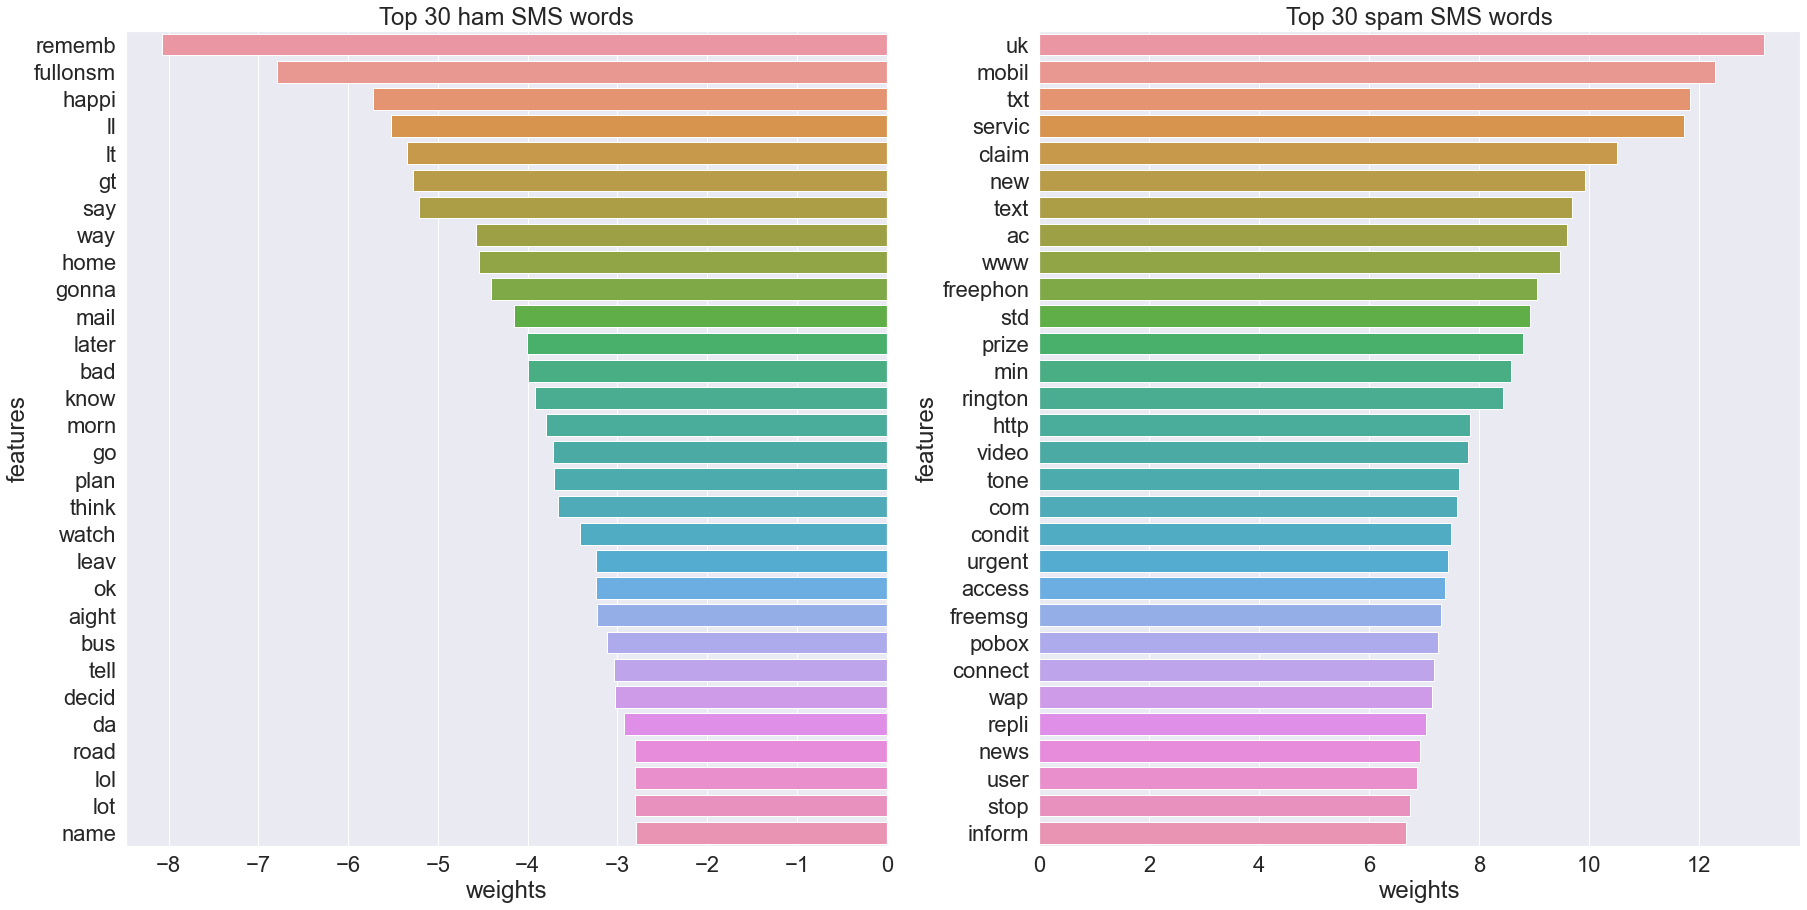

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 15), facecolor='w', edgecolor='k')

top_ham_model_weights = model_weights[model_weights['weights'] < 0][:30]
sns.barplot(x='weights', y='features', data=top_ham_model_weights, ax=axes[0])
axes[0].set_title('Top 30 ham SMS words')

top_spam_model_weights = model_weights[model_weights['weights'] >= 0][:30]
sns.barplot(x='weights', y='features', data=top_spam_model_weights, ax=axes[1])
axes[1].set_title('Top 30 spam SMS words')

plt.show()

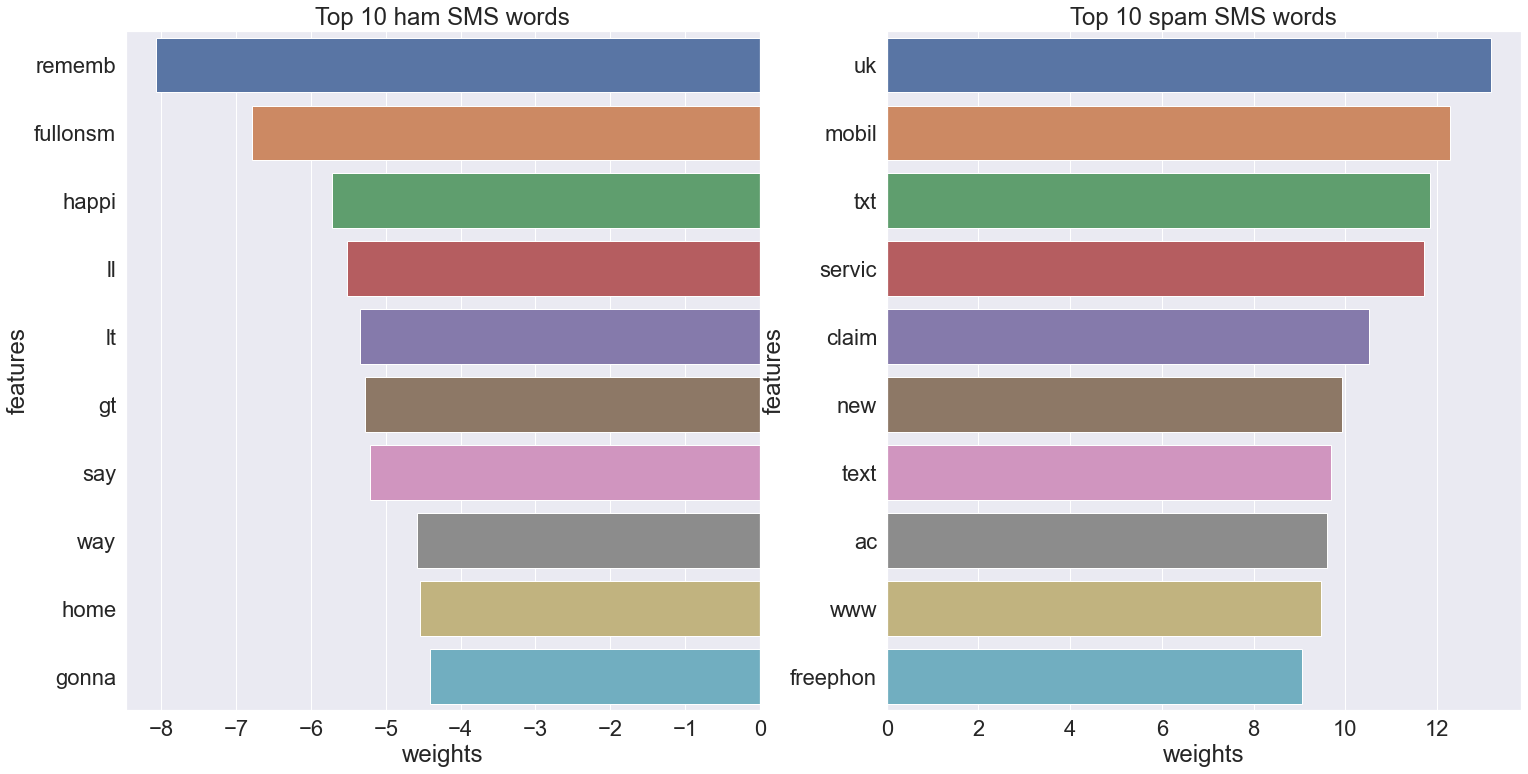

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12.5), facecolor='w', edgecolor='k')

top_ham_model_weights = model_weights[model_weights['weights'] < 0][:10]
sns.barplot(x='weights', y='features', data=top_ham_model_weights, ax=axes[0])
axes[0].set_title('Top 10 ham SMS words')

top_spam_model_weights = model_weights[model_weights['weights'] >= 0][:10]
sns.barplot(x='weights', y='features', data=top_spam_model_weights, ax=axes[1])
axes[1].set_title('Top 10 spam SMS words')

plt.show()

#### Local surrogate model - Decision Tree

We train a KNN classifier for our local surrogate model to obtain test instance neighbors.

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
knn_clf = KNeighborsClassifier(n_neighbors=100, weights='distance')
knn_clf.fit(new_x_train, new_y_train)

KNeighborsClassifier(n_neighbors=100, weights='distance')

We select the third test instance, with index 1044 in the test set, which is classified as spam, to obtain its neighbors.

In [39]:
y_test.loc[1044]

1

In [40]:
x_test, y_test

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 3245    0
 944     0
 1044    1
 2484    0
 812     1
        ..
 668     0
 218     0
 5536    0
 1657    0
 3875    0
 Name: label, Length: 1393, dtype: int64)

In [41]:
test_instance = [x_test[2]]
y_test.loc[1044]

1

In [42]:
instance_y = knn_clf.kneighbors(test_instance, n_neighbors=100, return_distance=False)

We make yet another set of new xs and ys, using the instance neighbors.

In [43]:
new_x_train2, new_y_train2 = [], []
for i in instance_y[0]:
    new_x_train2.append(new_x_train[i])
    new_y_train2.append(new_y_train[i])

We train our local surrogate model.

In [44]:
decision_tree_surrogate = DecisionTreeClassifier(max_depth=30)
decision_tree_surrogate.fit(new_x_train2, new_y_train2)

DecisionTreeClassifier(max_depth=30)

We measure the fidelity.

In [45]:
y_surrogate_pred_test = log_reg_surrogate.predict(new_x_train2)
print("Fidelity:", metrics.accuracy_score(new_y_train2, y_surrogate_pred_test))

Fidelity: 1.0


And display a plot of the local surrogate decision tree.

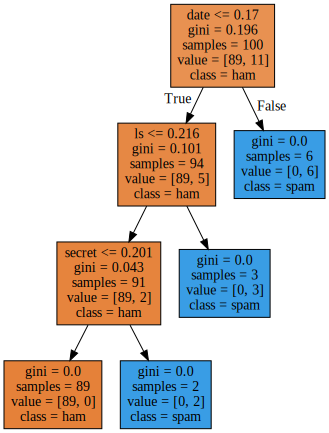

In [46]:
decision_graph = Source(
    export_graphviz(decision_tree_surrogate, 
                    feature_names=list(feature_names), 
                    class_names=target_names, 
                    filled=True)
)

with open('local_surrogate_logReg.png', 'wb') as f:
    f.write(decision_graph.pipe(format='png'))

SVG(decision_graph.pipe(format='svg'))

### Variable importance - Permutation importance

As a final approach, we will measure the permutation importance of different features on a Logistic regression model.

In [47]:
import eli5
from eli5.sklearn import PermutationImportance

We train our model.

In [48]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

We obtain the test set prediction and print the classification report.

In [49]:
y_predicted_test = log_reg.predict(x_test)
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1202
        spam       0.98      0.70      0.81       191

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.89      1393
weighted avg       0.96      0.96      0.95      1393



We calculate the feature importance.

In [70]:
importance = PermutationImportance(log_reg).fit(x_test, y_test)
eli5.show_weights(importance, top=None, feature_names=list(feature_names))

Weight,Feature
0.0056 ± 0.0014,txt
0.0042 ± 0.0011,win
0.0039 ± 0.0007,text
0.0036 ± 0.0009,repli
0.0033 ± 0.0007,min
0.0029 ± 0.0009,privat
0.0029 ± 0.0009,code
0.0027 ± 0.0006,expir
0.0026 ± 0.0007,redeem
0.0024 ± 0.0011,identifi
